# Age Predictor

In [1]:
#import all req. packages

import numpy as np
import pandas as pd
import csv

import datetime
from datetime import datetime, timedelta
import time

from sklearn import preprocessing
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#import csv files

Pos = pd.read_csv('data\positions.csv')
Edu = pd.read_csv('data\education.csv')
Sen = pd.read_csv('data\jobtitle_seniority.csv')

Since the database is only 100,000 users this is easily handled onboard locally. At scale, the pipeline should make use of a SQL Database for example to compute and merge. 

## 0. Basic Feature Creation/Deletion

### Datetime

An date object that allows for easier date actions later. Relplacing the string format.

In [3]:
#change column formats
#changing to 'datetime' format for easy operations later

Pos['startdate'] = pd.to_datetime(Pos.startdate)
Pos['enddate'] = pd.to_datetime(Pos.enddate)

Edu['startdate'] = pd.to_datetime(Edu.startdate)
Edu['enddate'] = pd.to_datetime(Edu.enddate)

### User ID

A master list of the 100,000 unique users.

In [4]:
# Creating a master list of unique users

master_users = pd.unique(Sen.user_id)
master_users = pd.Series(master_users, name = 'user_id')

### Time Duration for Degrees and Jobs

We want a feature that decribes not specific starting and end times but relative distances between them. This can be a helpful feature in detrmining the outcome.

In [5]:
#add 'durations' between start and end dates for use later

Edu['degduration'] = Edu.enddate - Edu.startdate 
Pos['jobduration'] = Pos.enddate - Pos.startdate 

### Number of: Jobs, Degrees

A good metric may be just the number of degrees or jobs someone has listed.
A better version may be a time (duration) weighted number of job/degree features. 

In [6]:
# dataframe for job and degree number

job_num = Pos.groupby('user_id')['jobtitle'].size()
print(job_num.size)
deg_num = Edu.groupby('user_id')['major'].size()
print(deg_num.size)

print('Examples of jobs by user:' + '\n' )
print(job_num.head())
print('\n'+'Examples of degrees by user:' + '\n' )
print(deg_num.head())

# id with most degrees

print('\n'+'Most degrees awarded to: (*drumroll*)'+'\n')
print(deg_num.index[deg_num.argmax()],':',deg_num.max())

81464
100000
Examples of jobs by user:

user_id
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    1
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    2
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    9
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    2
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    9
Name: jobtitle, dtype: int64

Examples of degrees by user:

user_id
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    1
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    2
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    1
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    1
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3
Name: major, dtype: int64

Most degrees awarded to: (*drumroll*)

JBrqCQYzF+vs0NvzCbRnIQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ== : 44


### Job Title/Degree Major -  *delete*

I plan on deleting the job titles and degree names for the purposes of our machine model as it is not worth sorting and properly labeling all the possibile variations. Yet this will be used in creating our age determination by hand for our training set. 

In [7]:
# delete 'job title' from positions table

#Pos.drop('jobtitle',axis = 1, inplace = True)

## 1. Data Visualization

We apply this step of looking at our data to determine visually any intresting features or insights. Also helpful with data cleaning step later.

### Seniority

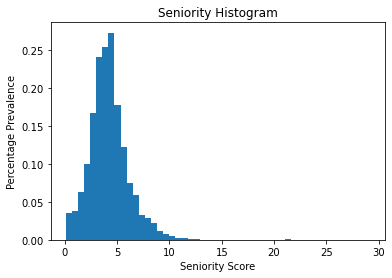

Range of seniority: count    416295.000000
mean          4.197873
std           1.878557
min           0.084932
25%           3.042827
50%           4.066610
75%           5.099970
max          29.186301
Name: seniority, dtype: float64


In [8]:
plt.hist(Sen.seniority, bins = 50, density = True)
plt.title('Seniority Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Seniority Score')
plt.show()

#looking at the range of seniority 

print("Range of seniority:", Sen.seniority.describe())

### Positions (duration)

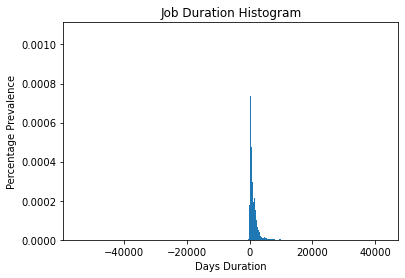

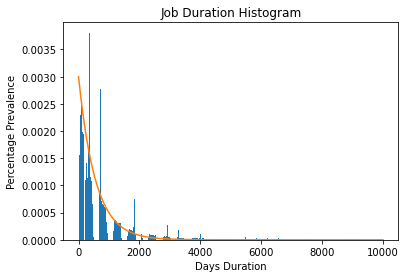

In [9]:
plt.hist(Pos.jobduration.dt.days, density = True,bins = int((Pos.jobduration.size)**.5))
plt.title('Job Duration Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Days Duration')
plt.show()

plt.hist(Pos.jobduration.dt.days, density = True,bins = int((Pos.jobduration.size)**.5), range = [0,10000])
plt.title('Job Duration Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Days Duration')
X = np.linspace(0,10000, 100000)
plt.plot(X, .003*np.exp(-.0018*X))
plt.show()

Notice the Periodicity. Likley due to yearly turn around for each season or the way the data is recorded as years without month and date. This could be verified with more visualizations.

Also, notice the exponential-like decay of job holders. Cool! This would possibly translate to every year people have a random, and independent of the past, chance of quiting that is more or less the same. More or less that is... 

More close up analysis is required (as it may have small bumps or more inverse power behavior) , but may be important in the ultimate parent goal of the project of job retention. 

In [10]:
print("Sorted values:" + '\n')
print((Pos.jobduration.dt.days).sort_values())

print("Examples:" + '\n')

print(Pos.iloc[247738])
print(Pos.iloc[170850])
print(Pos.iloc[77136])

Sorted values:

247738   -54303.0
170850   -16041.0
77136    -12691.0
315319   -12601.0
176319   -12268.0
           ...   
377571        NaN
377572        NaN
377576        NaN
377583        NaN
377584        NaN
Name: jobduration, Length: 377585, dtype: float64
Examples:

user_id        2ZqyX5k9cZmzulxrou6zbHAG1BvSkUYANepQVJd0smgtpB...
jobtitle       owner_construction_representative_project_fiel...
startdate                                    2158-05-06 00:00:00
enddate                                      2009-09-01 00:00:00
jobduration                                -54303 days +00:00:00
Name: 247738, dtype: object
user_id        lJwwedMiLpW57ysdkpnlLw4ZM3TcQvn1bQ/jHgHWG0kf/b...
jobtitle       sales_marketing_intern_|_information_technolog...
startdate                                    2013-12-01 00:00:00
enddate                                      1969-12-31 00:00:00
jobduration                                -16041 days +00:00:00
Name: 170850, dtype: object
user_id        RdpI

We can see that we have a few issues with job duration. We have negative entries, zero entries and null entries. 

There are many reasons for negative entries (such as reversal of start end dates or incorrect year), but the possibilities are too numerous so they likley will have to be dropped. 

In [11]:
Pos[(Pos.jobduration == pd.Timedelta("0 days"))].head(5)

,user_id,jobtitle,startdate,enddate,jobduration
23,2GjvthKY91+eZ7VnbFQePHAG1BvSkUYANepQVJd0smgtpB...,amazon_warehouse_associate,2016-01-01,2016-01-01,0 days
33,MYldBNEckSRfZ59/Yo0QyQ5+2cvffV/mNepQVJd0smgtpB...,key_makeup_artist_hairstylist_actor,2017-02-01,2017-02-01,0 days
34,sXmVRmJYl5tYFCGeCUD/NA5+2cvffV/mNepQVJd0smgtpB...,commis_de_cuisine,2006-01-01,2006-01-01,0 days
60,mQ6pu4rozD/EufUIFsmQtA4ZM3TcQvn1bQ/jHgHWG0kf/b...,author_presenter,2008-01-01,2008-01-01,0 days
111,8kSefFmshKoHtT3ANru37g5+2cvffV/mNepQVJd0smgtpB...,production_assistant_runner,2014-02-01,2014-02-01,0 days


Zeros are likley someone who just stayed at a job for less than year so they wrote just the same year once for the position. The average time for such a possibility is .25 - .5 years at the company. The other possibility is that the start date was just mistakenly rewritten into the end date. Looking at the sample above we see that it is most likley the first possibility as there are no repeat instances for a user_id even though the avergae number of positions per person is 2-3. Meaning this only happens for one of theor entries ussualy, not all of them.  

The high range of 10,000 days is resonable as it is less than 28 years. 

### Positions (start and end date)

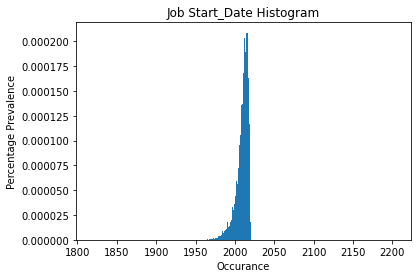

count                           368526
mean     2009-01-29 23:25:03.570440192
min                1817-09-01 00:00:00
25%                2006-01-01 00:00:00
50%                2011-04-01 00:00:00
75%                2014-09-01 00:00:00
max                2204-02-01 00:00:00
Name: startdate, dtype: object


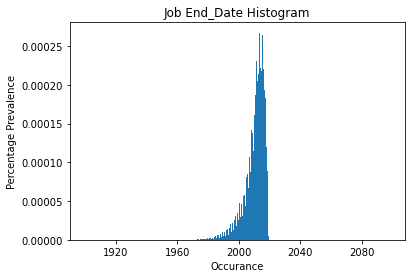

count                           270354
mean     2010-05-23 17:12:14.477019136
min                1900-01-01 00:00:00
25%                2007-09-01 00:00:00
50%                2012-02-01 00:00:00
75%                2015-02-01 00:00:00
max                2098-01-01 00:00:00
Name: enddate, dtype: object

In [12]:
plt.hist(Pos.startdate, density = True,bins = int((Pos.jobduration.size)**.45))
plt.title('Job Start_Date Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Occurance')
plt.show()

print(Pos.startdate.describe(datetime_is_numeric=True))

plt.hist(Pos.enddate, density = True,bins = int((Pos.jobduration.size)**.45))
plt.title('Job End_Date Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Occurance')
plt.show()

Pos.enddate.describe(datetime_is_numeric=True)

The position start dates have ranges that are impractical. The end dates are also empty at times because there was no termination to date (current day) at the time of recording the data. 

### Education (duration)

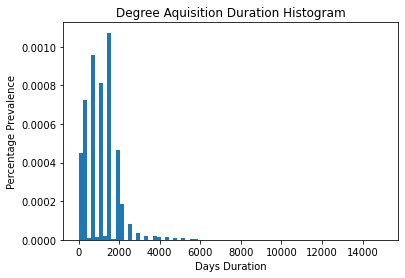

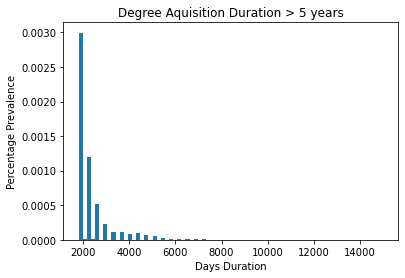

count    189246.000000
mean       1119.311452
std         960.389051
min      -13514.000000
25%         730.000000
50%        1096.000000
75%        1461.000000
max       76699.000000
Name: degduration, dtype: float64

Examples greater than 4000 days (approx. 11 years):

17      5113.0
81      4018.0
249     4383.0
289    12783.0
346     6940.0
347     4748.0
685     4018.0
690     4748.0
705    14975.0
771     4018.0
Name: degduration, dtype: float64

Looking at a couple full entries:

user_id        rRV4R2AmBxB+1pMZ61Wm4Q4ZM3TcQvn1bQ/jHgHWG0kf/b...
major                                           Bachelors Degree
startdate                                    1997-01-01 00:00:00
enddate                                      2011-01-01 00:00:00
degduration                                   5113 days 00:00:00
Name: 17, dtype: object
user_id        5bdDBEJ3x5rZHkRCcKWOtA4ZM3TcQvn1bQ/jHgHWG0kf/b...
major                                                High School
startdate                    

In [13]:
plt.hist(Edu.degduration.dt.days, density = True,bins = int((Edu.degduration.size)**.35), range = [0,15000])
plt.title('Degree Aquisition Duration Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Days Duration')

plt.show()

plt.hist(Edu.degduration.dt.days, density = True,bins = int((Edu.degduration.size)**.35), range = [1800,15000])
plt.title('Degree Aquisition Duration > 5 years')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Days Duration')

plt.show()

# The most extreme degree duration times

print(Edu.degduration.dt.days[~Edu.degduration.isnull()].describe())

# examples of greater than 4000 day durations (about 11 years) for a degree
print('\n' + "Examples greater than 4000 days (approx. 11 years):" + '\n')
print(Edu.degduration.dt.days[Edu.degduration.dt.days > 4000].head(10))

print('\n' + 'Looking at a couple full entries:' '\n')
print(Edu.iloc[17])
print(Edu.iloc[690])

We note a couple of interesting things:
1. Some of the degrees take an enormous amount of time. Many of these are actually their pre-university school achievement namely 1st - 12th grades. See second example above. The other kind is very long standing degrees. The longest type of appropriate degrees are Ph.D.'s which we cap at 10 years. This will be filtered in the later section. 
2. We notice that the 'High School' label is actually a great determinant of age as little is likley to interrupt their progess to school graduation as apposed to later achivements. 

### Education (start and end date)

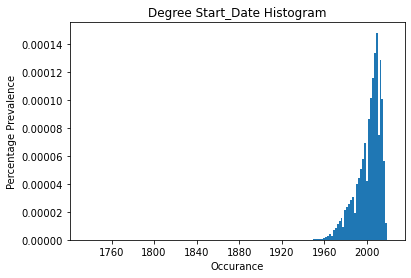

count                           197556
mean     2001-10-12 02:18:10.736803584
min                1735-01-01 00:00:00
25%                1996-01-01 00:00:00
50%                2005-01-01 00:00:00
75%                2010-01-01 00:00:00
max                2021-01-01 00:00:00
Name: startdate, dtype: object


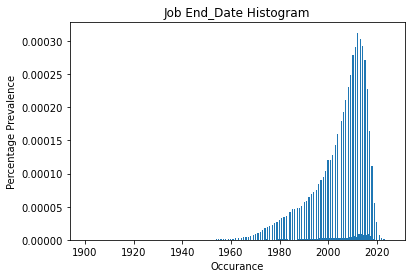

count                           190658
mean     2004-08-13 15:12:13.111644800
min                1900-01-01 00:00:00
25%                1999-01-01 00:00:00
50%                2008-01-01 00:00:00
75%                2013-01-01 00:00:00
max                2025-01-01 00:00:00
Name: enddate, dtype: object

Highest 100 start date entries:
175138   2019-01-01
36577    2019-01-01
182641   2019-01-01
122105   2019-01-01
7097     2019-01-01
            ...    
171797   2021-01-01
28510    2021-01-01
111371   2021-01-01
182857   2021-01-01
86276    2021-01-01
Name: startdate, Length: 100, dtype: datetime64[ns]

Highest 100 end date entries:
133640   2022-01-01
106839   2022-01-01
26881    2022-01-01
33615    2022-01-01
102379   2022-01-01
            ...    
27109    2025-01-01
87629    2025-01-01
31691    2025-01-01
22219    2025-01-01
218777   2025-01-01
Name: enddate, Length: 100, dtype: datetime64[ns]


In [14]:
plt.hist(Edu.startdate, density = True,bins = int((Edu.startdate.size)**.41))
plt.title('Degree Start_Date Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Occurance')
plt.show()

print(Edu.startdate.describe(datetime_is_numeric=True))

plt.hist(Edu.enddate, density = True,bins = int((Edu.enddate.size)**.45))
plt.title('Job End_Date Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Occurance')
plt.show()

print(Edu.enddate.describe(datetime_is_numeric=True))

print('\n'+ "Highest 100 start date entries:")
print(Edu.startdate.sort_values(na_position = 'first').tail(100))

print('\n'+ "Highest 100 end date entries:")
print(Edu.enddate.sort_values(na_position = 'first').tail(100))


Both have inappropriate ranges in the far past. Note the future entries seem to be expected graduation dates.

## 2. Data Cleaning

Some of our data entries have holes in the features we plan on using to determine the age. We can appraoch null entries two ways:
1. We can just delete incomplete data entries from our set. This deletion has the downside of possibly criticaly reducing our data set if even one element is missing. Additionally we may want to determine the age of someone who has incomplete data. (Easy)

2. We can replace missing entries with some intelligently "neutral" replacement that will be handled well in the learning phase. (Hard)

In [15]:
# number of degrees with no time stamp

noedu = Edu.degduration.isnull()
print("Number of degrees with no time stamp:", np.sum(noedu))

# number of jobs with no time stamp

nojob = Pos.jobduration.isnull()
print("Number of jobs with no time stamp:", np.sum(nojob))

Number of degrees with no time stamp: 36938
Number of jobs with no time stamp: 107280


In [16]:
# number of degrees with same start-end time stamp

edusame = Edu.degduration == pd.Timedelta("0 days")
print("Number of degrees with same start-end time stamp:",np.sum(edusame))

# number of jobs with same start-end time stamp

jobsame = (Pos.jobduration == pd.Timedelta("0 days"))
print("Number of jobs with same start-end time stamp:",np.sum(jobsame))



Number of degrees with same start-end time stamp: 16872
Number of jobs with same start-end time stamp: 7352


### Position

There seems to be a sharp drop off of end dates and start dates around Feb. 2019. I assume thats around when the data was collected and finalized.

I filter out:

Entries with jobs starting or ending after May 2019 and anything starting before 1940 which is approximatley 80 years ago. See visualization section. I also keep all 'Null' type values as they are important in feature creation later. I will deal with these values later after merging. 

Entries with job durations that are negative or 'Null' due to *both* missing start and end dates for the entry.

In [17]:
# Removing extreme dates before 1940 and in the "future" after May 2019, we keep 'Null' values

# Conditions for removal

condition1 = ((Pos.startdate > '1940-01-01') & (Pos.startdate < '2019-06-01')) | (Pos.startdate.isnull())
condition2 = ((Pos.enddate > '1940-01-01') & (Pos.enddate < '2019-06-01')) | (Pos.enddate.isnull())
condition3 = (Pos.jobduration.dt.days > -1) | (Pos.startdate.isnull() & Pos.enddate.notnull()) | (Pos.startdate.notnull() & Pos.enddate.isnull()) 

# Replace, having deleted entries of Position dataframe

Pos = Pos[(condition1 & condition2 & condition3)]


print("number of removed entries:")
print('Condition 1:',np.sum(~condition1))
print('Condition 2:',np.sum(~condition2))
print('Condition 3:',np.sum(~condition3))

print('Total:',np.sum(~condition1)+np.sum(~condition2)+np.sum(~condition3))

number of removed entries:
Condition 1: 39
Condition 2: 9
Condition 3: 10265
Total: 10313


Many jobs have the same starting and end date, likley because the job was under one year and they only wrote their year in (which defaults to the beginning of the year). I will switch these to the next year with give them about a 6 month average duration.
Some jobs may have not put an ending date becuase they never left their jobs. We do not want to eliminate these positions. 

In [18]:
# For data we have calculating the distribution of job length when we know its under a year
print(Pos[Pos.jobduration.dt.days < 365].describe())

# index of entries where start end end date are the same
ind = (Pos.jobduration.dt.days == 0)
print('\n',"Number of Jobs with same start-end date:",np.sum(Pos.jobduration.dt.days == 0))

# change the end date to next year
Pos.enddate[ind] = Pos.startdate[ind] + pd.Timedelta("365 days")

# change the job duration to 150 days
Pos.jobduration[ind] = pd.Timedelta("150 days")

                       jobduration
count                        91000
mean   154 days 11:33:55.305494502
std    101 days 06:38:23.432381193
min                0 days 00:00:00
25%               61 days 00:00:00
50%              151 days 00:00:00
75%              243 days 00:00:00
max              364 days 00:00:00

 Number of Jobs with same start-end date: 7351


Additionally, we are going to calculate the date in which we can say they probably have not left their job yet and fill it out with the average time at a job (instead of removing the entries).

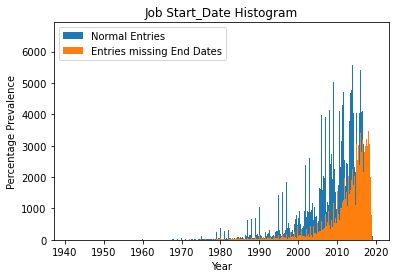

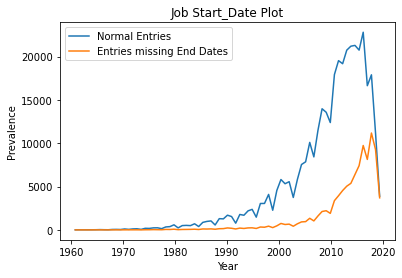

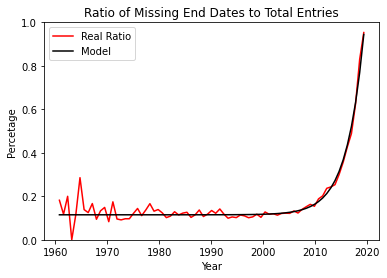

In [19]:
# normal entries and entries with only missing end dates
N = Pos.startdate
M = Pos.startdate[(Pos.startdate.notnull() & Pos.enddate.isnull())]

plt.hist(N,bins = int((Pos.jobduration.size)**.5))
plt.hist(M,bins = int((Pos.jobduration.size)**.45))
plt.title('Job Start_Date Histogram')
plt.ylabel('Percentage Prevalence')
plt.xlabel('Year')
plt.legend(['Normal Entries','Entries missing End Dates'])
plt.show()

# Converts datetime to seconds
def tickers(dt):
    return (dt - datetime(1970, 1, 1)) / timedelta(seconds=1)

#ignoring matplotlib warning
import warnings
warnings.filterwarnings("ignore")

# removing the 'Null' values
N = Pos.startdate[np.isfinite(Pos.startdate)]
N_sec = tickers(N)
M_sec = tickers(M)
# left right boundry of grid
left  = np.min(N_sec)
right = np.max(M_sec)
#number of bins
b = 100
X = np.linspace(left,right,b)
Y1,X1 = np.histogram(N_sec, bins = b)
Y2,X2 = np.histogram(M_sec, bins = X1)
#converts grid from seconds back to years
X = 1970 + X/31536000
#number of left bins to skip
s = b//4

plt.plot(X[s:],Y1[s:])
plt.plot(X[s:],Y2[s:])
plt.title('Job Start_Date Plot')
plt.ylabel('Prevalence')
plt.xlabel('Year')
plt.legend(['Normal Entries','Entries missing End Dates'])
plt.show()

#partial probability distribution
# 'd'                    : probability randomly missed end date entry
# 'a*np.exp(b*(year-c))' : probability job did not come to term
def p(year):
    a = .05
    b = .3
    c = 2010
    d = .115
    return a*np.exp(b*(year-c))+d

plt.plot(X[s:],(Y2/Y1)[s:], color = 'r')
plt.plot(X[s:],p(X[s:]), color = 'k')
plt.title('Ratio of Missing End Dates to Total Entries')
plt.ylabel('Percetage')
plt.xlabel('Year')
plt.legend(['Real Ratio','Model'])
plt.ylim([0, 1])
plt.show()

We clearly see that there is an abvious uptick in the ratio after 2010. Usually around 12% of people enevitably miss recording an end date no matter the era. The reason we see an uptick close to the end is likely due to those jobs not have not come to term. We even explicitly construct a probabilty function over time that tells us how likley that person just forgot or just has not finshed their job. 

In [20]:
print('Average time at a job:')
print(Pos.jobduration.describe())
print('Number of people with no end date after 2017 (as 3 years ):')
print(np.sum(Pos.enddate[Pos.startdate > '2017-01-01'].isnull()))

Average time at a job:
count                          269030
mean      971 days 03:45:18.325837296
std      1309 days 20:52:08.910555552
min                  28 days 00:00:00
25%                 242 days 00:00:00
50%                 577 days 00:00:00
75%                1156 days 00:00:00
max               24472 days 00:00:00
Name: jobduration, dtype: object
Number of people with no end date after 2017 (as 3 years ):
22262


I may replace missing end dates with the mean or something more sophisticated, not sure yet. This also would effect he job duration feature. I can remove them to start and chanage it afterward.

### Education

Remove Values before 1940 in both start and end dates. Future values seem to be in order. See visulaization.

In [21]:
# Removing extreme dates before 1940, we remove 'Null' values although we have recorded the number in advance.

# Conditions for removal

condition1 = ((Edu.startdate > '1940-01-01') | (Edu.startdate.isnull()))
condition2 = ((Edu.enddate > '1940-01-01') | (Edu.enddate.isnull()))
#condition3 = (Edu.degduration.dt.days > -1) #gets rid of all negative and null values
condition3 = (Edu.degduration.dt.days > -1) | (Edu.startdate.isnull() & Edu.enddate.notnull()) | (Edu.startdate.notnull() & Edu.enddate.isnull()) #gets rid of all negative and null values

# Replace, having deleted entries of Position dataframe

Edu = Edu[(condition1 & condition2 & condition3)]


print("number of removed entries:")
print('Condition 1:',np.sum(~condition1))
print('Condition 2:',np.sum(~condition2))
print('Condition 3:',np.sum(~condition3))

print('Total:',np.sum(~condition1)+np.sum(~condition2)+np.sum(~condition3))

number of removed entries:
Condition 1: 43
Condition 2: 17
Condition 3: 27424
Total: 27484


## 3. Feature Creation

### Max Time in Workforce

Here we create a feature that tells us how long the person has been involved with jobs from ealiest position to latest.

(Optional) We also create the possibilty if the max start date outways the last end date to replace it.

In [22]:
# Dataframe list for both the start of the first job
# and the end date of their last job

first_start = Pos.groupby('user_id').agg({'startdate': [np.min]})
first_start = first_start['startdate']['amin']

inter = Pos.groupby('user_id').agg({'startdate': [np.max]})
inter = inter['startdate']['amax']

last_end = Pos.groupby('user_id').agg({'enddate': [np.max]})
last_end = last_end['enddate']['amax']

# (Optional)
# If missing end date leads to higher start date than highest end date: replace
key = ((inter > last_end) | last_end.isnull())
last_end[key] = inter

# Joins the two data frames by user ID of critical extreme values
crt_work = pd.merge(first_start,last_end, on = 'user_id', how = 'outer')
#one final null pass
crt_work = crt_work.loc[crt_work.amin.notnull()]
crt_work = crt_work.loc[crt_work.amax.notnull()]
crt_work

#max lifetime part of the workplace
max_work = crt_work['amax'] - crt_work['amin']
max_work = max_work.rename("max_work")

Note that we can be missing information here if the final end date is missing, for a number of reasons, such as the job is still ongoing. We leave information on the table because it does not account for at least the start date of the final job. This can be coded in with a bit more work but I assume its effects are minimal.  

### Accumulated Studies

We include a feature that can be described as amount of time spent studying. This an accumulation of time spent studing not a simple distance in time. It discludes gaps between studies or even has a higher count for parallel studies. 

In [23]:
acc_stu = (Edu.fillna(pd.Timedelta("0 days"))).groupby('user_id').agg({'degduration': [np.sum]})
acc_stu = acc_stu['degduration']['sum']
acc_stu = acc_stu.rename("acc_stu")
#(acc_stu/pd.Timedelta("1 days")).plot.hist(bins = 100)

### Max-Average/Mixed Seniority

We need to reduce seniority scores to one number for each person for a few reasons:

1. The simplest and most obvious is just to extract the highest score for the person.

2. Yet the former assumes high confidence in the scores. Therefore an average score may be better. 

3. The final idea is that a weighted sum sort of score is ideal. We can base it on the number of scores, with increasing or diminishing returns.


In [24]:
max_seni = Sen.groupby('user_id').agg({'seniority': [np.max,np.mean]})
max_seni.describe()

seniority               
                amax           mean
count  100000.000000  100000.000000
mean        5.555866       4.237419
std         2.177644       1.489968
min         0.140639       0.140639
25%         4.213699       3.313264
50%         5.182183       4.080006
75%         6.646630       4.953036
max        29.186301      29.186301

### Earliest Activity

Here we create a baseline for each person of their earliest (or a weighted version) recorded activity the reported whether a degree or a job. We will start with degree.

In [25]:
#earliest degree's end

fir_deg = Edu.groupby('user_id').agg({'enddate': [np.min]})
fir_deg = fir_deg['enddate']['amin']
# inter2 = Edu.groupby('user_id').agg({'enddate': [np.min]})
# inter2 = inter2['enddate']['amin']
#inter2[(inter2 < beg_deg)]
fir_deg = fir_deg[fir_deg.notnull()]

# Converts datetime to numerical non-negatives, millions of seconds from 1900
def tickerz(dt):
    return (dt - datetime(1900, 1, 1)) / timedelta(seconds=1)

fir_tick = (tickerz(fir_deg)/10**6)
fir_tick.rename("fir_tick")

user_id
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    1672.5312
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    2461.4496
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3660.5952
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3345.0624
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3061.0656
                                                              ...    
zzdHAVxl9iQrwom22S/FLg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    2966.3712
zzrNxfUzwZXNkSs15haLyA4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    2587.6800
zzrbQXjc2yHwbWjtQ9F3mg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3534.3648
zzuZVPanBvW09lNk1C3h+Q5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3597.5232
zzvZxBSf81furoFl3PcSuHAG1BvSkUYANepQVJd0smgtpBr4MGMFJQ==    3818.4480
Name: fir_tick, Length: 89701, dtype: float64

## 4.  Merging

Create one big dataframe with all of our features.

In [26]:
#initial data merging

names = {"major": "num_deg", "jobtitle": "num_job", "amax": "max_sen", "mean": "avg_sen" }

data = pd.merge(deg_num,job_num, on = 'user_id', how = 'outer').fillna(0)

data = pd.merge(data,max_seni.seniority, on = 'user_id', how = 'right')

data = pd.merge(data,max_work.dt.days, on = 'user_id', how = 'left')
data.max_work[data['max_work'].isnull()] = 0.0

data = pd.merge(data,acc_stu.dt.days, on = 'user_id', how = 'left')
data.acc_stu[data['acc_stu'].isnull()] = 0.0

#add offset
data['offset'] = np.ones(100000)
#data = pd.merge(data,fir_deg, on = 'user_id', how = 'left')

data.rename(columns = names, inplace = True)
data

,num_deg,num_job,max_sen,avg_sen,max_work,acc_stu,offset
user_id,,,,,,,
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,1,1.0,7.064817,7.064817,0.0,1461.0,1.0
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,2,2.0,7.334247,5.332877,3165.0,2922.0,1.0
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,1,9.0,4.307247,3.854684,1553.0,1095.0,1.0
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,1,2.0,5.002740,4.465550,822.0,1826.0,1.0
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,3,9.0,7.421538,4.072623,6118.0,732.0,1.0
...,...,...,...,...,...,...,...
zzdHAVxl9iQrwom22S/FLg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,3,13.0,10.008219,5.389630,7486.0,1827.0,1.0
zzrNxfUzwZXNkSs15haLyA4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,2,1.0,4.610625,4.610625,0.0,1827.0,1.0
zzrbQXjc2yHwbWjtQ9F3mg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,1,0.0,3.865393,3.160607,0.0,1461.0,1.0


# 4. Training 

### Supervised Subset 

We will use a subset of users who provided us with high school information to more accuratley determine a true age or ground truth. I assume they were born 17-18 years before their high school end date. We should remove the high school entries as it directly determined the outcome. 

We use a few names for secondary higher education a.k.a. "high school" see link: https://en.wikipedia.org/wiki/Secondary_school
Yet many words can not be correctly distingished, as in the case with the spanish "Bachillerato" meaning high school but in Peru describing what we would call a bachelor's degree. 

In [27]:
# indices of a significant amount of high school degrees

hs_index1 = Edu.major.str.contains('h.s. diploma|high sc|highsch|high-sch|hs diploma|gymnasium', case = False, na=False)
hs_index2 =  (Edu.major == 'HS')
hs_index3 =  (Edu.major == 'H.S.C.')
hs_index4 =  (Edu.major == 'H.S.C')
hs_index5 =  (Edu.major == 'HSC')
hs_index6 =  (Edu.major.str.lower() == 'HS'.lower())
hs_index6[hs_index6.isnull()] = False
hs_index7 =  (Edu.major.str.match('higher secondary', case = False, na=False))
hs_index7[hs_index7.isnull()] = False
hs_index8 =  (Edu.major.str.match('Senior Secondary', case = False, na=False))
hs_index8[hs_index8.isnull()] = False
hs_index9 =  (Edu.major.str.match('onderwijs', case = False, na=False))
hs_index9[hs_index9.isnull()] = False

hs_index = (hs_index1 | hs_index2 | hs_index3 | hs_index4 | hs_index5 | hs_index6 | hs_index7 | hs_index8 | hs_index9)

#batch of high school graduates 
high_schoolers = Edu[hs_index]
#adding their supposed birthdays
high_schoolers['Birthday'] = high_schoolers['enddate'] - pd.Timedelta("6570 days") #18 years
#cleanup
high_schoolers.drop(labels = ['major','startdate','enddate','degduration'], axis = 1, inplace = True)
high_schoolers.set_index('user_id', inplace = True)
high_schoolers = high_schoolers.squeeze()

high_schoolers = high_schoolers[(high_schoolers.notnull())]

print ('Number of users with high school info:', np.sum(high_schoolers.notnull()))

Number of users with high school info: 3841


In [28]:
#Masking information about high school as the earliest acivity
#anyway assuming this is generally the case
Ed  = Edu[~hs_index]
fir_act = Ed.groupby('user_id').agg({'enddate': [np.min]})
fir_act = fir_act['enddate']['amin']
fir_act = fir_act[fir_act.notnull()]
fir_tack = (tickerz(fir_act)/10**6)
fir_tack.rename("fir_tack")

user_id
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    1672.5312
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    2461.4496
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3660.5952
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3345.0624
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3061.0656
                                                              ...    
zzdHAVxl9iQrwom22S/FLg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    2966.3712
zzrNxfUzwZXNkSs15haLyA4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    2587.6800
zzrbQXjc2yHwbWjtQ9F3mg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3534.3648
zzuZVPanBvW09lNk1C3h+Q5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    3597.5232
zzvZxBSf81furoFl3PcSuHAG1BvSkUYANepQVJd0smgtpBr4MGMFJQ==    3818.4480
Name: fir_tack, Length: 88736, dtype: float64

In [29]:
supervised_data = pd.merge(data, high_schoolers, on = 'user_id', how = 'inner')

supervised_data = pd.merge(fir_tack, supervised_data, on = 'user_id', how = 'inner')
supervised_data.rename(columns = {'amin' : 'fir_tack'}, inplace = True)
supervised_data.head()

,fir_tack,num_deg,num_job,max_sen,avg_sen,max_work,acc_stu,offset,Birthday
user_id,,,,,,,,,
+2SCsvjwjkYFFfBDQvYArHAG1BvSkUYANepQVJd0smgtpBr4MGMFJQ==,3439.7568,2,5.0,5.123407,4.255430,3500.0,366.0,1.0,1990-01-05
+8GBZvyzW0kHyziIFdNk1MuPeVF1KPE3NepQVJd0smgtpBr4MGMFJQ==,3439.7568,2,10.0,3.496862,2.244472,4383.0,1827.0,1.0,1989-01-05
+91xndvpW//3xmL7pGU2CQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,3313.5264,4,8.0,6.722116,3.797680,2892.0,8402.0,1.0,1987-01-06
+AtHffnVt9GRbOZRYN4ePg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,3250.3680,4,0.0,8.990813,6.001047,0.0,5844.0,1.0,1992-01-06
+D51K9aoFp97wFSO6wAbJg4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,3155.6736,2,3.0,3.456164,3.264814,5416.0,2191.0,1.0,1978-01-05


### Spliting into Training and Testing

Here we do a 65-35 as determined by the optimal scaling law. Especially since we have very few entries for training.

In [30]:
#make birthdays numeric 
supervised_data['Birthday'] = tickerz(supervised_data['Birthday'])/10**6

In [31]:
from sklearn.model_selection import train_test_split
#discover scaling law split
columns = 8
test = 1/np.sqrt(columns)
train = 1 - test
print(test)
print(train)
#Scaling Law Split
X_train, X_test, y_train, y_test = train_test_split(supervised_data.loc[:,'fir_tack':'acc_stu'], supervised_data['Birthday'], train_size= .65, random_state= 42)

0.35355339059327373
0.6464466094067263


### Model: Linear Regressor (Elastic Net)

The Linear regressor algorithms do not need heavy normalization as it won't use any kind of descent but linear algebra algoritmic iterations. 

Minimum mean squared error:
 170.00282174987143 @ alpha =  0.38383838383838387 ratio: 0.0
Minimum mean squared error:
 170.00269211891217 @ alpha =  0.5050505050505051 ratio: 0.25
Minimum mean squared error:
 170.00251125763808 @ alpha =  0.686868686868687 ratio: 0.5
Minimum mean squared error:
 170.0024441930921 @ alpha =  1.1717171717171717 ratio: 0.75
Minimum mean squared error:
 170.03151749876355 @ alpha =  2.0 ratio: 1.0


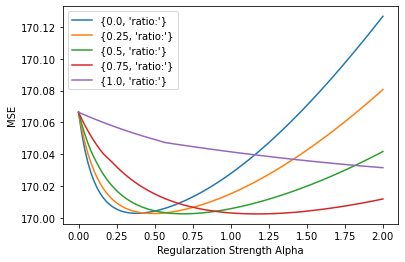

In [32]:
for k in np.linspace(0,1,5):
    #for storing performance values:
    num = 100
    P =np.zeros((num,2))
    #coefficent Storing
    C = np.zeros((num,7))
    j = 0
    for i in np.linspace(0,2,num):
        #make model object
        regr = ElasticNet(random_state=40, l1_ratio = k, alpha = i)
        #learn coefficents
        regr.fit(X_train,y_train)
        y_pred = regr.predict(X_test)

        #calculate mean squared error (square rooted)
        p = np.sqrt(((y_pred-y_test)**2).mean())

        C[j] = regr.coef_
        P[j][:] = np.array([i,p])
        j= j+1

    a = P[P[:,1].argmin(),0]
    m = P[:,1].min()
    print("Minimum mean squared error:"+ '\n',m, "@ alpha = ", a, 'ratio:',k)
    plt.plot(P[:,0],P[:,1], label = {'ratio:', k})
    
plt.ylabel('MSE')
plt.xlabel('Regularzation Strength Alpha')
plt.legend()
plt.show()

#print("Coefficient Values:")
#pd.DataFrame(C[P[:,1].argmin()]).set_index(regr.feature_names_in_ )

In [33]:
#make model object
regr = ElasticNet(random_state=40, l1_ratio = .75, alpha = 1.17 )
#learn coefficents
regr.fit(X_train,y_train)
y_pred = regr.predict(X_test)
#calculate mean squared error (square rooted)
print("Minimum mean squared error:",np.sqrt(((y_pred-y_test)**2).mean()))
print("R^2 score:", regr.score(X_test,y_test))

print("Coefficient Values:")
pd.DataFrame(regr.coef_).set_index(regr.feature_names_in_ )

Minimum mean squared error: 170.00244439703707
R^2 score: 0.7834438623188673
Coefficient Values:


,0
fir_tack,0.775513
num_deg,4.401283
num_job,10.854280
max_sen,-2.548956
avg_sen,-14.128584
max_work,-0.022905
acc_stu,0.010732


Note it makes sense that the 'fir_tick' (or ealiest activity) has a coefficient close to 1 as it is directly and expliclty used if you were to do this by hand. What you are really doing is determining every single person's relative distance from original "first activity"  to the time  when they were born in the past.

The performance is not that strong. We could add non-linear or cross features to try and improve but we just move on.

### Model: Decision Tree (Random Forest)

Random Forests tends to behave well as they can be discontinous and weed out many features as they "decide" which are better to use.Since we have so few features this seems like overkill. But here we are. 

Minimum mean squared error:
 140.74873437742392 Max samples: 0.968421052631579 Max features: 3
Minimum mean squared error:
 141.4104112285479 Max samples: 1.0 Max features: 4
Minimum mean squared error:
 142.86225195117234 Max samples: 0.968421052631579 Max features: 5


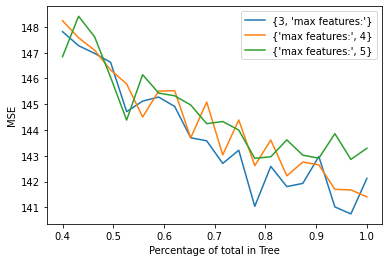

In [34]:
for k in range(3,6):
    #for storing performance values:
    num = 20
    P =np.zeros((num,2))
    j = 0
    for i in np.linspace(0.4,1,num):
        #make model object
        modl = RandomForestRegressor(max_samples = i, max_features = k, max_depth = 100)
        modl.fit(X_train,y_train)
        y_pred = modl.predict(X_test)

        #calculate mean squared error (square rooted)
        p = np.sqrt(((y_pred-y_test)**2).mean())

        #C[j] = modl.coef_
        P[j][:] = np.array([i,p])
        j= j+1

    a = P[P[:,1].argmin(),0]
    m = P[:,1].min()
    print("Minimum mean squared error:"+ '\n',m, 'Max samples:', a, 'Max features:',k)
    plt.plot(P[:,0],P[:,1], label = {'max features:', k})
    
plt.ylabel('MSE')
plt.xlabel('Percentage of total in Tree')
plt.legend()
plt.show()

#print("Coefficient Values:")
#pd.DataFrame(C[P[:,1].argmin()]).set_index(regr.feature_names_in_ )

In [35]:
#make model object
modl = RandomForestRegressor(max_samples = .9, max_features = 3, max_depth = 1000)
#learn coefficents
modl.fit(X_train,y_train)
y_pred = modl.predict(X_test)
#calculate mean squared error (square rooted)
print("Minimum mean squared error:",np.sqrt(((y_pred-y_test)**2).mean()))
print("R^2 score:", modl.score(X_test,y_test))

print("Feature Importance:")
pd.DataFrame(modl.feature_importances_).set_index(regr.feature_names_in_ )

Minimum mean squared error: 143.69576219343517
R^2 score: 0.8452794196338659
Feature Importance:


,0
fir_tack,0.597356
num_deg,0.020120
num_job,0.019642
max_sen,0.049112
avg_sen,0.089853
max_work,0.175254
acc_stu,0.048663


This model performed better in all metrics we have.

### Model: Neural Network (ReLu)

Neural networks are unnecessarily complex especially for the low number of features we have. Yet here will be normalizing our features as they will be affected by magnitude.

In [36]:
x = X_train.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_tr = pd.DataFrame(x_scaled)
#X_tr.rename(columns = {'0':'fir_tack', '1':'num_deg', '2':'num_job','3': 'max_sen', '4': 'avg_sen', '5':'max_work', '6': 'acc_stu'}, inplace = True)
X_tr['7']=1.0

x = X_test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
X_te = pd.DataFrame(x_scaled)
#X_tr.rename(columns = {'0':'fir_tack', '1':'num_deg', '2':'num_job','3': 'max_sen', '4': 'avg_sen', '5':'max_work', '6': 'acc_stu'}, inplace = True)
X_te['7']=1.0

In [37]:
model = Sequential()
#Hidden layers same size in width
layers = 4
width= 8*np.ones(layers, dtype = int)
model.add(Dense(width[0], input_dim = 8, activation = 'relu', kernel_initializer='normal'))
for i in range(1,layers):
    model.add(Dense(50*width[i], activation = 'relu'))
model.add(Dense(1, activation='linear'))
#model.summary()
model.compile(optimizer = 'ADAM', loss = 'mean_squared_error', metrics = ['mse','mae'])
model.fit(X_tr,y_train, epochs = 300, batch_size=100)

Epoch 1/300
17/17 [==============================] - 1s 3ms/step - loss: 6937775.5000 - mse: 6937775.5000 - mae: 2607.7837
Epoch 2/300
17/17 [==============================] - 0s 4ms/step - loss: 6831955.5000 - mse: 6831955.5000 - mae: 2587.3931
Epoch 3/300
17/17 [==============================] - 0s 3ms/step - loss: 5937121.5000 - mse: 5937121.5000 - mae: 2406.2751
Epoch 4/300
17/17 [==============================] - 0s 4ms/step - loss: 2439942.7500 - mse: 2439942.7500 - mae: 1429.0132
Epoch 5/300
17/17 [==============================] - 0s 3ms/step - loss: 314922.5312 - mse: 314922.5625 - mae: 430.3789
Epoch 6/300
17/17 [==============================] - 0s 4ms/step - loss: 178164.7344 - mse: 178164.7344 - mae: 361.2480
Epoch 7/300
17/17 [==============================] - 0s 4ms/step - loss: 138307.2344 - mse: 138307.2344 - mae: 283.0777
Epoch 8/300
17/17 [==============================] - 0s 4ms/step - loss: 124291.2578 - mse: 124291.2578 - mae: 281.0915
Epoch 9/300
17/17 [=========

17/17 [==============================] - 0s 4ms/step - loss: 29955.1582 - mse: 29955.1582 - mae: 117.6368
Epoch 70/300
17/17 [==============================] - 0s 4ms/step - loss: 29794.0469 - mse: 29794.0469 - mae: 116.8702
Epoch 71/300
17/17 [==============================] - 0s 4ms/step - loss: 29862.2383 - mse: 29862.2383 - mae: 116.0069
Epoch 72/300
17/17 [==============================] - 0s 5ms/step - loss: 29772.2266 - mse: 29772.2266 - mae: 115.6749
Epoch 73/300
17/17 [==============================] - 0s 4ms/step - loss: 29697.3184 - mse: 29697.3184 - mae: 115.6605
Epoch 74/300
17/17 [==============================] - 0s 5ms/step - loss: 29700.0078 - mse: 29700.0078 - mae: 116.8645
Epoch 75/300
17/17 [==============================] - 0s 4ms/step - loss: 29780.1055 - mse: 29780.1055 - mae: 115.1000
Epoch 76/300
17/17 [==============================] - 0s 5ms/step - loss: 29822.8164 - mse: 29822.8164 - mae: 115.8855
Epoch 77/300
17/17 [==============================] - 0s 5ms/

17/17 [==============================] - 0s 4ms/step - loss: 28800.5645 - mse: 28800.5645 - mae: 109.1577
Epoch 138/300
17/17 [==============================] - 0s 4ms/step - loss: 28776.2422 - mse: 28776.2422 - mae: 109.2645
Epoch 139/300
17/17 [==============================] - 0s 4ms/step - loss: 28827.4941 - mse: 28827.4941 - mae: 109.7798
Epoch 140/300
17/17 [==============================] - 0s 4ms/step - loss: 29007.8262 - mse: 29007.8262 - mae: 108.6341
Epoch 141/300
17/17 [==============================] - 0s 4ms/step - loss: 29134.9336 - mse: 29134.9336 - mae: 110.9096
Epoch 142/300
17/17 [==============================] - 0s 4ms/step - loss: 28899.5918 - mse: 28899.5918 - mae: 109.3362
Epoch 143/300
17/17 [==============================] - 0s 4ms/step - loss: 29408.9180 - mse: 29408.9180 - mae: 111.4411
Epoch 144/300
17/17 [==============================] - 0s 4ms/step - loss: 29163.7246 - mse: 29163.7246 - mae: 111.3395
Epoch 145/300
17/17 [==============================] -

17/17 [==============================] - 0s 4ms/step - loss: 28635.4023 - mse: 28635.4023 - mae: 109.2182
Epoch 206/300
17/17 [==============================] - 0s 4ms/step - loss: 28931.3789 - mse: 28931.3789 - mae: 109.8820
Epoch 207/300
17/17 [==============================] - 0s 4ms/step - loss: 29881.0547 - mse: 29881.0547 - mae: 112.8451
Epoch 208/300
17/17 [==============================] - 0s 4ms/step - loss: 29081.9434 - mse: 29081.9434 - mae: 112.4137
Epoch 209/300
17/17 [==============================] - 0s 4ms/step - loss: 28725.6152 - mse: 28725.6152 - mae: 108.3395
Epoch 210/300
17/17 [==============================] - 0s 4ms/step - loss: 28899.0449 - mse: 28899.0449 - mae: 111.3851
Epoch 211/300
17/17 [==============================] - 0s 4ms/step - loss: 28955.1875 - mse: 28955.1875 - mae: 110.0627
Epoch 212/300
17/17 [==============================] - 0s 5ms/step - loss: 28940.7988 - mse: 28940.7988 - mae: 110.2217
Epoch 213/300
17/17 [==============================] -

17/17 [==============================] - 0s 5ms/step - loss: 29184.4688 - mse: 29184.4688 - mae: 110.9995
Epoch 274/300
17/17 [==============================] - 0s 5ms/step - loss: 30314.8867 - mse: 30314.8867 - mae: 115.0856
Epoch 275/300
17/17 [==============================] - 0s 4ms/step - loss: 29330.2227 - mse: 29330.2246 - mae: 112.3423
Epoch 276/300
17/17 [==============================] - 0s 4ms/step - loss: 29726.1699 - mse: 29726.1699 - mae: 113.5090
Epoch 277/300
17/17 [==============================] - 0s 4ms/step - loss: 30724.4512 - mse: 30724.4512 - mae: 117.8752
Epoch 278/300
17/17 [==============================] - 0s 4ms/step - loss: 29614.5840 - mse: 29614.5840 - mae: 111.5587
Epoch 279/300
17/17 [==============================] - 0s 6ms/step - loss: 29118.5527 - mse: 29118.5527 - mae: 109.8132
Epoch 280/300
17/17 [==============================] - 0s 6ms/step - loss: 29810.3066 - mse: 29810.3066 - mae: 113.3571
Epoch 281/300
17/17 [==============================] -

In [38]:
y_p = model.predict(X_te)
a = y_test.mean()
r_sq = 1-np.sum((y_test.values-y_p.transpose())**2)/np.sum((y_p.transpose()-a)**2)
#calculate mean squared error (square rooted)
p = np.sqrt(((y_test.values-y_p.transpose())**2).mean())
print("Minimum mean squared error:"+ '\n',p)
print("R^2 score:", r_sq)

Minimum mean squared error:
 223.940877056548
R^2 score: 0.683212349700639


The Neural Network did not perform that well either. 

## 5. Final Results

We find that the Random Forest performed the best and we will go forward with that model.

I also assume that our ground truth was a bit messy and noisy and avergaed a bunch of things so predictive power was reduced besides the fact that our information is fundemntally lacking to determine with high accuracy: age. 

We also include a few functions that translate our results to age and birthday.

In [39]:
#add a last bit of data to our main unsupervised dataset
data = pd.merge(fir_tick, data, on = 'user_id', how = 'inner')
data.drop(columns = ['offset'], inplace = True)
data.rename(columns = {'amin' : 'fir_tick'}, inplace = True)

#function converts seconds since 1900 to year 
def anno(t):
    return 1900+(((t)*10**6)/(60*60*24*365))

#returns age given birth year
def age(y):
    today = pd.to_datetime("today")
    return 1900 + anno(tickerz(today))/10**6 - y

#Predict birth moments using  Random Forest
y = modl.predict(data)
datacopy = data 
datacopy['bday'] = anno(y)
datacopy['bday'].rename('birth year', inplace = True)
print('Example predictions for birth years:')

datacopy['age'] = age(datacopy['bday'])
datacopy['age'].rename('age', inplace = True)

Example predictions for birth years:


user_id
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    70.963871
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    62.615049
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    30.607158
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    38.298693
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    50.779980
                                                              ...    
zzdHAVxl9iQrwom22S/FLg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    52.433076
zzrNxfUzwZXNkSs15haLyA4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==    59.797597
zzrbQXjc2yHwbWjtQ9F3mg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    39.002868
zzuZVPanBvW09lNk1C3h+Q5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==    32.093871
zzvZxBSf81furoFl3PcSuHAG1BvSkUYANepQVJd0smgtpBr4MGMFJQ==    27.861898
Name: age, Length: 89701, dtype: float64

                                                     birth year        age
user_id                                                                   
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bH...  1950.945699  70.963871
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bH...  1959.294521  62.615049
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr...  1991.302411  30.607158
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr...  1983.610877  38.298693
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr...  1971.129589  50.779980
...                                                         ...        ...
zzdHAVxl9iQrwom22S/FLg5+2cvffV/mNepQVJd0smgtpBr...  1969.476493  52.433076
zzrNxfUzwZXNkSs15haLyA4ZM3TcQvn1bQ/jHgHWG0kf/bH...  1962.111973  59.797597
zzrbQXjc2yHwbWjtQ9F3mg5+2cvffV/mNepQVJd0smgtpBr...  1982.906701  39.002868
zzuZVPanBvW09lNk1C3h+Q5+2cvffV/mNepQVJd0smgtpBr...  1989.815699  32.093871
zzvZxBSf81furoFl3PcSuHAG1BvSkUYANepQVJd0smgtpBr...  1994.047671  27.861898

[89701 rows x 2 columns]

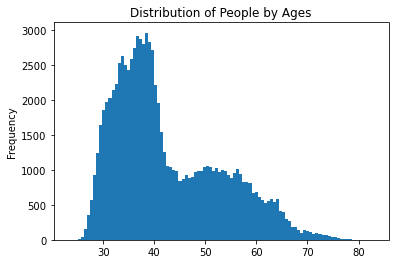

In [40]:
Ages = pd.merge(datacopy.bday, datacopy.age, on = 'user_id', how = 'inner')
print(Ages)
Ages.age.plot.hist(bins = 100, title = 'Distribution of People by Ages')
print('Interesting, does not look very continuous. Must mean possibly that the algorithm needs some more work.' )

In [41]:
#final formatting
hs_true = age(1900 +((high_schoolers-pd.Timestamp('1900-01-01'))/pd.Timedelta("1 days"))/365)
hs_true.rename('age', inplace = True)
Ages = pd.merge(Ages,hs_true, on = 'user_id', how = 'left')
Ages.age_x[Ages.age_y.notnull()] = Ages.age_y
Ages['true_or_predicted'] = 1.0
Ages.true_or_predicted[Ages.age_y.notnull()] = 'true'
Ages.true_or_predicted[Ages.age_y.isnull()] = 'predicted'
Ages.drop(columns = ['age_y','birth year'], inplace = True)
Ages.rename(columns={"age_x": "age"}, inplace = True)
Ages

,age,true_or_predicted
user_id,,
++5SW5MI5/h8X1hMA3QnmQ4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,70.963871,predicted
++5qk2+uEmkI/3Z4FrBwDw4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,62.615049,predicted
++6+hv3i5RAVsrWO8q5JEQ5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,30.607158,predicted
++6zEVtPCi83vpPTHSY2Vg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,38.298693,predicted
++7kB6m0hI1TgAPmyY1X6A5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,50.779980,predicted
...,...,...
zzdHAVxl9iQrwom22S/FLg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,52.433076,predicted
zzrNxfUzwZXNkSs15haLyA4ZM3TcQvn1bQ/jHgHWG0kf/bHrn17MPg==,59.797597,predicted
zzrbQXjc2yHwbWjtQ9F3mg5+2cvffV/mNepQVJd0smgtpBr4MGMFJQ==,39.002868,predicted
